<a href="https://colab.research.google.com/github/waltergkaturuza/Machine-Learning-for-Climate-and-Weather/blob/main/tier_3/observations/mooc_tier3_1_ml_sat_panegrossi_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  <h1><center>ECMWF MOOC MACHINE LEARNING IN WEATHER AND CLIMATE</center></h1>

   <h2><center>Tier 3: Practical ML application in weather and climate - OBSERVATIONS</center></h2>
   
   <h2><center> Exercise on how to build a simple ANN model for satellite precipitation retrieval using passive microwave measurements </center></h2>

 <h3><center>Created by: Daniele Casella, Paolo Sanò, Leo Pio D'Adderio, Riccardo D'Ercole </center></h3>
  <h3><center> CNR-ISAC, Rome Italy</center></h3>



## Introduction
This Jupiter Notebook is on how to build a simple Artificialt Neural Network (ANN) (Multilayer Perceptrons) for surface precipitation rate estimation using the GPM Microwave Imager (GMI) measurements as input. The training dataset is a small-size osbervational dataset built from coincident measurements of the GMI and the Dual-frequency Precipitation Radar (DPR) on board the NASA/JAXA GPM-Core Observatory. The ANN architecture is pre-defined and an optimal set of parameters for the training phase is provided. The goal is to define the ANN (the weights) by minimising the prediction error (the loss function) avoiding overfitting during training. As you go through this Jupiter Notebook, you will learn about GMI characteristics, definition of ANN architecture, key parameters in the training phase, minimisation of the loss function, and overfitting. The ANN model obtained will be applied to one case study. 

As First Task it is recommended that you go through the code and the plots provided, understanding the meaning of each step. As a second Task you may run the code, play with the parameters, and analyse the results. Please, consider that the training for each set of parameters can take a few minutes. 

you can run this code on [colab](https://colab.research.google.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_3/observations/mooc_tier3_1_ml_sat_panegrossi_v5.ipynb)

## Before starting: python and libraries installation

### Python
Python 3 is required for running this code on your machine. The fastest way to have python is to install the [Anaconda Package](https://www.anaconda.com/products/individual).  By the way, python can be installed on all OS, there are versions of Anaconda for Linux Mac and Windows, however this code has been tested for Linux Ubuntu and windows 64 bit OS. 

Before starting you need to install some additional software and some python packages.


### Libraries installation 

If you are using Anaconda the easiest way to get everything installed is to use conda (from a terminal or Anaconda Prompt in Windows) to create a new virtual environment:


<p style="background:black">
<code style="background:black;color:white"> 
  user@user:/home/user$ conda create -n tf tensorflow pandas scikit-learn matplotlib basemap xarray netCDF4 h5netcdf h5py wget
  user@user:/home/user$ conda activate tf
</code>
</p>

### run in colab

Otherwise if you are using colab you will need to install two libraries (wget and basemap), after the installation you will be asked to "restart runtime", you need to click on the "restart runtime" label.
It is convenient to run this code with GPU enabled, you can do that from the edit menu.


In [1]:
!pip install wget basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.3 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=d5ded4551a9aa4de0c8a19de15fa408913c63d1c858d0b0a85c743f2762239db
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


### Data download
    
    
Before running the notebook you need to download some data:

In [2]:
import wget
url = 'https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/observations/1C-R.GPM.GMI.XCAL2016-C.20200916-S130832-E144106.037225.V07A.HDF5'
filename = wget.download(url)
url = 'https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/observations/2A.GPM.GMI.GPROF2021v1.20200916-S130832-E144106.037225.V07A.HDF5'
filename = wget.download(url)
url = 'https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/observations/dataset2_GMI_DPR_RR.nc'
filename = wget.download(url)

# GMI - GPM Microwave Imager
The GMI is the most advanced spaceborne MW radiometer currently available, operating on the NASA/JAXA GPM Core Observatory (GPM-CO) launched in March 2014 (https://gpm.nasa.gov/). The GMI is a conical-scanning radiometer measuring vertically (V) and horizontally (H) polarised radiances in 13 channels between 10.65 and 183.31 GHz. Table 1 presents some details on GMI channels and their properties. In each channel the measured radiance, which is converted into brightness temperature (TB) for physical interpretation, results from the interaction of surface-emitted radiation with atmospheric water vapour and the liquid and solid hydrometeros within the cloud. Its 13 channels have different penetration ability in the cloud and are sensitive to different hydrometeor types and precipitation intensities. Complex retrieval algorithms convert the multichannel TBs in surface precipitation rate. There are several factors which makes the quantitative precipitation estimation from PMW radiometers (and from GMI) very challenging. Moreover, the relationhip between the multichannel TBs and surface rain rate is indirect and highly non linear, and machine learning techniques can be used to overcome some of these issues (e.g., Sanò et al., doi:10.3390/rs10071122) .


 No. | Central frequency (GHz) | Polarisation | IFOV size 
 :-: | :-: | :-: | :-: 
 1 | 10.65 | V | 19x32 km
 2 | 10.65 | H | 19x32 km
 3 | 18.7 | V | 11x18 km
 4 | 18.7 | H | 11x18 km
 5 | 23.8 | V | 9.2x15 km
 6 | 36.5 | V | 8.6x14 km
 7 | 36.5 | H | 8.6x14 km
 8 | 89.0 | V | 4.4x7.2 km
 9 | 89.0 | H | 4.4x7.2 km 	
10 | 166.5 | V | 4.4x7.2 km
11 | 166.5 | H | 4.4x7.2 km	
12 | 183.31 ± 3 | V | 4.4x7.2 km
13 | 183.31 ± 7 | V | 4.4x7.2 km	

<center><i>Table 1. GMI channels characteristics</i></center>

Now, we are ready to read the GMI files. The GMI files format is HDF5, and the "h5py" library has to be imported in order to be able to read the data. At the following link <a href="https://gpm.nasa.gov/resources/documents/file-specification-gpm-products/">GPM File Specification</a> you can find the document explaining the GMI file structure as well as the file structure of all Level 1 to Level 3 GPM products. The GPM products (including GMI) can be downloaded from <a href="https://storm.pps.eosdis.nasa.gov/storm/"> the NASA PPS Storm </a> website. In the following block we see how to open and read the content of a HDF5 file (i.e. the GMI file).

In [3]:
import h5py
gmi_file_path='./1C-R.GPM.GMI.XCAL2016-C.20200916-S130832-E144106.037225.V07A.HDF5'
hf=h5py.File(gmi_file_path,'r')
dataset1=hf['S1']
print(dataset1.keys())


<KeysViewHDF5 ['ScanTime', 'SCstatus', 'Latitude', 'Longitude', 'sunLocalTime', 'Quality', 'incidenceAngle', 'sunGlintAngle', 'incidenceAngleIndex', 'Tc']>


### GMI TB Imagery
In the following block, we are going to see how to create TB imagery for selected GMI channels.

AttributeError: ignored

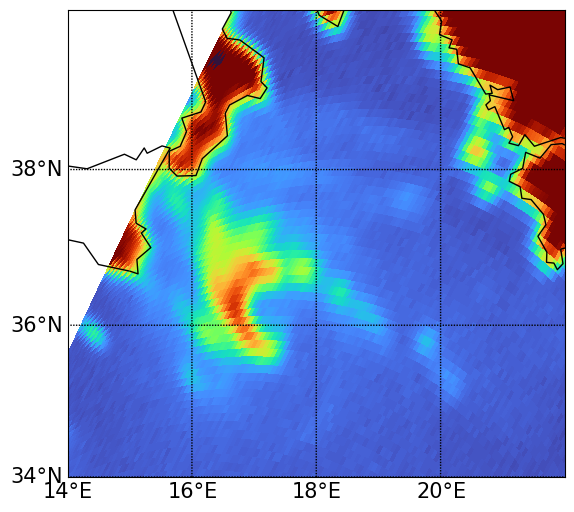

In [5]:
# defining the funcion to plot
def plot_tb_map(TB,lat,lon,colorAxisMin,colorAxisMax):
    # set the lat/lon borders of the map
    latborders=[34,40]
    lonborders=[14,22]
    m = Basemap(projection='merc',
        resolution='l',
        lat_ts=20,
        llcrnrlat=latborders[0],urcrnrlat=latborders[1],\
        llcrnrlon=lonborders[0],urcrnrlon=lonborders[1])

    
#E set min/max values of the colorbar
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        im1 = m.pcolor(lon[:],lat[:],TB[:],shading='nearest',cmap='turbo',latlon=True,vmin=colorAxisMin,vmax=colorAxisMax)
    m.drawcoastlines()
    
# set parallels and meridians
    dparal=2 #separation in deg between drawn parallels
    parallels = np.arange(latborders[0],latborders[1],dparal)
    dmerid=2 #separation in deg between drawn meridians
    meridians = np.arange(lonborders[0],lonborders[1],dmerid)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=15)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=15) 
# add colorbar.
    cbar = m.colorbar(location='right',pad="5%")
    cbar.set_label('K')



#windows users may need to set an environmental variable before
#import os
#os.environ["PROJ_LIB"] = 'C:'+os.sep+'Users'+os.sep+'Leo'+os.sep+'anaconda3'+os.sep+'Library'+os.sep+'share'; #with your anaconda installation path

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap 
from mpl_toolkits.basemap import Basemap
import numpy as np
import h5py
import warnings

gmi_file_path='./1C-R.GPM.GMI.XCAL2016-C.20200916-S130832-E144106.037225.V07A.HDF5'
hf=h5py.File(gmi_file_path,'r')

dataset1=hf['S1']
dataset2=hf['S2']
lat1=hf['S1/Latitude'][:]
lon1=hf['S1/Longitude'][:]
TB=hf['S1/Tc'][:]
TB10v=TB[:,:,0]
TB10h=TB[:,:,1]
TB19v=TB[:,:,2]
TB19h=TB[:,:,3]
TB23v=TB[:,:,4]
TB37v=TB[:,:,5]
TB37h=TB[:,:,6]
TB89v=TB[:,:,7]
TB89h=TB[:,:,8]

lat2=hf['S2/Latitude'][:]
lon2=hf['S2/Longitude'][:]


TB=hf['S2/Tc'][:]
TB166v=TB[:,:,0]
TB166v[TB166v<0]=np.NaN
TB166h=TB[:,:,1]
hf.close()

fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(231)
plot_tb_map(TB10v,lat1,lon1,colorAxisMin=160,colorAxisMax=280)
plt.title('TB 10v')

ax = fig.add_subplot(232)
plot_tb_map(TB19v,lat1,lon1,colorAxisMin=180,colorAxisMax=280)
plt.title('TB 19v')

ax = fig.add_subplot(233)
plot_tb_map(TB23v,lat1,lon1,colorAxisMin=200,colorAxisMax=300)
plt.title('TB 23v')

ax = fig.add_subplot(234)
plot_tb_map(TB37v,lat1,lon1,colorAxisMin=210,colorAxisMax=280)
plt.title('TB 37v')

ax = fig.add_subplot(235)
plot_tb_map(TB89v,lat1,lon1,colorAxisMin=130,colorAxisMax=280)
plt.title('TB 89v')

ax = fig.add_subplot(236)
plot_tb_map(TB166v,lat1,lon1,colorAxisMin=140,colorAxisMax=300)
plt.title('TB 166v')

plt.show()



The panels show the GMI brightness temperatures (TBs) for the overpass which captured the Mediterranean Hurricane (Medicane) named Ianos on 16/09/2020 over the Ionian Sea between Southern Italy and Greece.
The first row of panels shows the low frequency channels (< 30 GHz) affected mostly by the emission of radiation by the rain droplets, which results in higher TBs with respect to the radiatively cold sea surface background (warm areas in the imagery are associated to the precipitation in the rain bands around the cyclone center). The second row of panels shows the higher frequency channels, where the effect of the scattering by the ice on the observed TBs becomes visible as cold areas in the imagery. The scattering signal at 37 GHz and 89 GHz channel (low TBs) are due to the larger (and denser) frozen hydrometeors (hail/graupel) found in the convective cores, while at higher frequency the scattering is due to the smaller size/less dense ice in the upper cloud layers.  The following table summaries the properties of the six GMI frequencies (for further details please refer to D'Adderio et al.,10.1016/j.atmosres.2022.106174).   

 <table>
    
  <tr>
    <th style="text-align:center"> GMI channel</th>
    <th style="text-align:center"> TB warmer than background</th>
    <th style="text-align:center"> TB colder than background</th>
  </tr>
  <tr>
    <td style="text-align:center"> 10 GHz</td>
    <td style="text-align:center"> emission from large raindrops (lower rain layers) </td>
    <td style="text-align:center"> - </td>
  </tr>
  <tr>
    <td style="text-align:center"> 19 GHz</td>
    <td style="text-align:center"> emission from large raindrops (rain)</td>
    <td style="text-align:center"> - </td>
  </tr>
  <tr>
    <td style="text-align:center"> 22 GHz</td>
    <td style="text-align:center"> emission from large raindrops (rain)<br>emission from  water vapour</td>
    <td style="text-align:center"> - </td>
  </tr>    
  <tr>
    <td style="text-align:center"> 37 GHz</td>
    <td style="text-align:center"> emission from raindrops (rain)</td>
    <td style="text-align:center"> Scattering by large and dense ice<br>(e.g. hail – deep convection)</td>
  </tr>
  <tr>
    <td style="text-align:center"> 89 GHz</td>
    <td style="text-align:center"> emission from water vapour<br>and cloud liquid water</td>
    <td style="text-align:center"> Scattering by precipitating heavily rimed ice<br>(e.g., graupel – convection/deep convection)</td>
  </tr>
    <tr>
    <td style="text-align:center"> 166 GHz</td>
    <td style="text-align:center"> emission from water vapour<br>and cloud liquid water</td>
    <td style="text-align:center"> Scattering by less dense ice<br>(snowflakes and aggregates – stratiform/convective precip)</td>
  </tr>
</table> 
<center><i>Table 2. Properties of some GMI channels related to clouds and precipitation.</i></center>


# Exercise: training a simple artificial neural network model

This section explains how to train a Multilayer Perceptrons (MLP) Neural Network which predicts the target variable or label (surface rain rate) given a set of 13 pre-defined inputs or features (TBs). The model represents a simple Neural Network (NN) with two hidden layers and a final layer which is used to predict the target label.

The section is composed by the following parts:

1) Data loading and conversion
<br>
2) Dataset description
<br>
3) Training and test data split
<br>
4) Model training 
<br>
5) Model evaluation
<br>
6) Further training of the model and overfitting
<br>
7) Testing the trained model on the initial case study

<div class="alert alert-block alert-warning">
<b>Warning </b> The neural network that will be trained during this exercise is not suitable for scientific/operational purposes, the main limitation comes from the training dataset, which is very small (10 orbits) with respect to the ones used in scientific/operational algorithms, which can include hundreds of thousands of orbits and millions of pixels. Using very large training dataset is of paramount importance for obtaining a model that is general, i.e. a model that performs with the same accuracy when applied to the training or to an independent dataset.
</div>

### 1) Data loading and conversion
First, we will import all the libraries which are necessary to this exercise.
<br>
After loading the data in xarray format, which is one of the most common Python libraries to process netcdf files, the data is transformed into tensors which is the standard format for training Machine Learning or Deep Learning models. 
<br> For the purpose of this exercise, we will use the Tensorflow framework, which is built on top of Keras Python library in order to train a Neural Network.
<br> We observe that the features dataset have 61906 different records and 13 features, whereas the label dataset consist of one variable and 61906 records.

In [6]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import utils
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import xarray as xr
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

data_path = './dataset2_GMI_DPR_RR.nc'

ds = xr.open_dataset(data_path)

train_df = ds['tb'].to_dataframe().unstack()
target = ds['rr'].to_dataframe()

print('The shape of the features data is', train_df.shape)
print('The shape of the label data is', target.shape)

tensor_df = tf.convert_to_tensor(train_df, dtype=np.float)
label_df = tf.convert_to_tensor(target, dtype=np.float)

The shape of the features data is (61906, 13)
The shape of the label data is (61906, 1)


### 2) Dataset description

The dataset used for training and test of the NN is built from 10 GMI orbits (from 9th March 2014). The 13 features correspond exactly to the 13 GMI channels taken in the same order as in Table 1. The rainfall rate represents the target variable and has been obtained from the NASA GMI/DPR Level 2 precipitation product (2B-CMB). This algorithm combines GMI measurements with the reflectivity profiles measured by the Dual-frequency Precipitation Radar (DPR) on board the GPM Core Observatory, the first spaceborne radar operating at Ka and Ku band (see figure below) and provides vertical profiles of liquid and solid precipitation microphysics, and precipitation rate near the surface. Some details on the 2B-CMB algorithm can be found in <a href="https://gpm.nasa.gov/resources/documents/gpmdpr-level-2-algorithm-theoretical-basis-document-atbd/">GMI/DPR Level 2 Algorithm Theoretical Basis Document (ATBD) </a>.

The GMI TBs and the DPR rainfall rates (from 2B-CMB) have been matched to build the dataset using a nearest neighbour approach. Only pixels over ocean and sea where rainfall has been observed (2B-CMB rainfall rate > 0 mm/h) are selected to build the dataset (for a total of 61906 pixels).
![title](https://rmets.onlinelibrary.wiley.com/cms/asset/6e4beac5-ee9c-4de1-a780-0c34bd06987b/qj3313-fig-0001-m.jpg)
_from: Skofronick-Jackson et al. 2018 doi:10.1002/qj.3313_

### 3) Training and test data split
The objective of Machine Learning is to create a model which is able to learn from training data and consequently make consistent predictions in the presence of unseen data. In order to achieve this, the objective is to minimize a loss function. This is done by identifying a vector of model weights which minimizes the loss function. 
<br>
<br>
In order to train a Machine Learning model which is able to make successful predictions and therefore generalize sufficiently well in the presence of indipendent data coming from the similar distribution, a standard practice is to divide the dataset into __training__ and __test sets__. Generally speaking, the Machine Learning best practice suggests to retain about 80% of the dataset for training and the rest 20% for test purpose. Another common practice is to divide the dataset into three sets, namely train, test and validation in order to tune the model hyperparameters (using the test) and then validate the model on an independent set (validation). 
<br>
<br> In our case, considering that our training set is quite small, we decide to opt for a __50%__ split between training and test set, to allow for a model testing on a comparable size dataset.

In [7]:
def split_dataset(dataset, label_dataset):
    
    choice=np.mod(range(0,len(tensor_df)),2)==0 #this variable is true for even positions in the obseravtions sequence 
    X_train = dataset[choice==0]
    X_test = dataset[choice]
    y_train = label_dataset[choice==0]
    y_test = label_dataset[choice]   
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(tensor_df, label_df)

# Scaling: Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #mean and variance are calculated on the training dataset and applied to the training dataset
X_test_scaled = scaler.transform(X_test)       #mean and variance (previously calculated) are applied to the test dataset


print( len(tensor_df))
print( X_train.shape)
print( X_test.shape)


61906
(30953, 13)
(30953, 13)


Subsequently we define the __model hyperparameters__, which influence the model ability to learn.
<br><br>
- The __learning rate__ is the model speed of the learning process: a too high learning rate can save some training time at the expenses of letting the model converge (i.e., minimizing the loss function); a small learning rate can significantly increase the training time and still fail to achieve an efficient minimum. By default, NNs are trained with a decreasing linear schedule, allowing for a constant decrease in the learning rate which helps the model converge.
<br>
- The __batch size__ is the number of samples to include in a single training iteration. The total number of batches can be obtained from: size of the training data/batch_size
<br>
- The number of __epochs__ is the number times that the learning algorithm will work through the entire training dataset
<br>
- Finally, setting the __verbose__ option equal to 1 allow us to obtain information on the training while in progress 

In [8]:
# model hyperparameters
learning_rate1= 0.001  #the learning rate is the step size at each iteration while moving toward a minimum of a loss function
epochs = 1600          #An epoch in machine learning means one complete pass of the training dataset through the algorithm. 
batch_size = 8000      #the batch size is the number of training examples utilized in one iteration. A large batch size should make the training faster but may lead to memory saturation


verbose = 1
# Set the input shape
input_shape = X_train.shape[1]
print(f'Feature shape: {input_shape}')

Feature shape: 13


### 4) Model training

We create a simple model architecture given the small training dataset. In this case we construct a MLP model with two hidden layers. The first layer contains 10 perceptrons, while the second is made of 20 perceptrons. We use a sigmoid activation function (transfer function used in both hidden layers). Finally, we use the mean squared error (MSE) as loss function to be minimised and display the mean average error (MAE) for each training iteration (epoch).
<br> By printing the model it is possible to observe the shape of each layer and the total number of weights to be updated with the training. 

In [9]:
# training phase with the training dataset
def train():
    # here the network achitecture is defined: it is a feed forward neural network with 2 hidden layers, 
    # 20 perceptrons in the fisrt hidden layer and 10 in the second. Sigmoids are used as transfer function in both hidden layers.
    model = Sequential()
    model.add(Dense(20, input_dim=input_shape, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(10, kernel_initializer='normal', activation='sigmoid')) ###second hidden
    model.add(Dense(1, kernel_initializer='normal', activation='linear')) #output
    model.summary()
    #the optimizer is the algorithm used for the training. Adam is a standard choice, but Scale conjugate gradient (SGD), is also very efficient.
    optimizer = optimizers.Adam(lr=learning_rate1)
    #optimizer = optimizers.experimental.SGD( learning_rate=learning_rate1)
    
    # here the model optimzer and the loss function to be minimized during training (mean squared error, MSE) are defined
    # the mean absolute error (mae) is also computed as additional metrics
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    
    # the training dataset, the batch size and the number of epochs to be used re defined
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
    # validation is also carried out
    # monitoring loss and metrics on the test dataset
    # at the end of each epoch
        validation_data=(X_test_scaled, y_test),)
    model.save('./mlp_model.h5') #the model is saved at the end of the training phase in an HFD5 output file
    return model, history

In [10]:
# for trainig with CPU (Slower) uncomment next line.
# model, history = train() 

# for trainig with GPU (Faster) uncomment next 2 lines. works in colab with GPU enabled
with tf.device("/device:GPU:0"):
    model, history = train()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                280       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1600
4/4 [==============================] - 1s 84ms/step - loss: 31.4899 - mae: 2.3369 - val_loss: 32.4718 - val_mae: 2.3212
Epoch 2/1600
4/4 [==============================] - 0s 23ms/step - loss: 31.3572 - mae: 2.3091 - val_loss: 32.3391 - val_mae: 2.2939
Epoch 3/1600
4/4 [==============================] - 0s 18ms/step - loss: 31.2254 - mae: 2.2821 - val_loss: 32.2057 - val_mae: 2.2675
Epoch 4/1600
4/4 [==============================] - 0s 21ms/step - loss: 31.0915 - mae: 2.2560 - val_loss: 32.0717 - val_mae: 2.2421
Epoch 5/1600
4/4 [==============================] - 0s 18ms/step - loss: 30.9571 - mae: 2.2307 - val_loss: 31.9363 - val_mae: 2.2176
Epoch 6/1600
4/4 [==============================] - 0s 21ms/step - loss: 30.8213 - mae: 2.2066 - val_loss: 31.7991 - val_mae: 2.1940
Epoch 7/1600
4/4 [==============================] - 0s 21ms/step - loss: 30.6840 - mae: 2.1832 - val_loss: 31.6592 - val_mae: 2.1712
Epoch 8/1600
4/4 [==============================] - 0s 20ms/step - lo

### 5) Model evaluation 

Here we plot the learning curves, i.e., the MAE obtained ad each iteration (epoch) as a function of the epoch number. By observing the learning curves, we clearly see that the training and test values of the loss function decrease with the number of epochs. However, the decreasing rate of the two curves slows down, and the two curves become almost flat somewhat near the 1400th epoch, which means that the training of the model is almost completed. Moreover, the two (train and test) loss curves are very similar to each other, this is a clear sign of the generalizability of the model. In other terms, if we train on a dataset and we get the same result on an indipendent test dataset (with different observations) we expect that the application of the model to any other dataset will still give the same accuracy (i.e., validation dataset which is not considered in this exercise).
<br> Overall, it is possible to observe that the two curves do not fully reach and asymptotic value, and it may be possible that a further training of the model brigns to slightly better results.

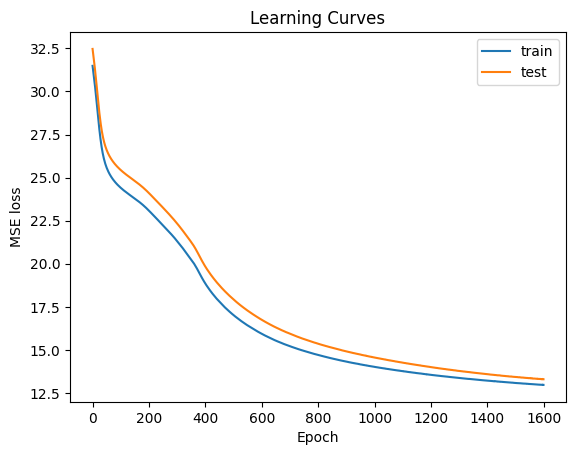

In [11]:
import matplotlib.pyplot as plt
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.plot((history.history['loss']), label='train')
plt.plot((history.history['val_loss']), label='test')
plt.legend()
plt.show()

### 6) Further training of the model and overfitting

The model can be further trained for even more Epochs, but it will be subject to overfitting. An overfitting model reproduces too closely the target variable in a specific training dataset, and may therefore fail to fit additional data or predict future observations reliably.  In other words, the model memorizes the training dataset too well, learning also the noise included, and it is not able to generalise any more. <br>The following code loads the model that has been trained in section 6 and trains it further for additional 1000 epochs, using the same training hyperparameters (learning rate, batch size, etc.).

In [12]:
# training phase with the training dataset
fine_tune_epochs = 1000
total_epochs =  epochs + fine_tune_epochs
def train_fine(model):

    optimizer = optimizers.Adam(lr=learning_rate1)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    history_fine = model.fit(
        X_train_scaled,
        y_train,
        batch_size=batch_size,
        epochs=total_epochs,
        initial_epoch=history.epoch[-1],
    # We also carry out some validation to
    # monitor loss and metrics on the test dataset
    # at the end of each epoch
        validation_data=(X_test_scaled, y_test),)
        #validation_data=(X_test, np.log10(y_test)),)
    model.save('./mlp_model_1.h5')
    return model, history_fine
new_model = tf.keras.models.load_model('./mlp_model.h5')

# for trainig with CPU (Slower) uncomment next line.
# model_fine, history_fine = train_fine(new_model)

# for trainig with GPU (Faster) uncomment next 2 lines. works in colab with GPU enabled
with tf.device("/device:GPU:0"):
    model_fine, history_fine = train_fine(new_model)


Epoch 1600/2600
4/4 [==============================] - 1s 61ms/step - loss: 12.9630 - mae: 1.4573 - val_loss: 13.2850 - val_mae: 1.4533
Epoch 1601/2600
4/4 [==============================] - 0s 19ms/step - loss: 12.9740 - mae: 1.4485 - val_loss: 13.2983 - val_mae: 1.4514
Epoch 1602/2600
4/4 [==============================] - 0s 18ms/step - loss: 12.9543 - mae: 1.4553 - val_loss: 13.2818 - val_mae: 1.4675
Epoch 1603/2600
4/4 [==============================] - 0s 20ms/step - loss: 12.9573 - mae: 1.4662 - val_loss: 13.2809 - val_mae: 1.4692
Epoch 1604/2600
4/4 [==============================] - 0s 20ms/step - loss: 12.9547 - mae: 1.4644 - val_loss: 13.2794 - val_mae: 1.4614
Epoch 1605/2600
4/4 [==============================] - 0s 18ms/step - loss: 12.9514 - mae: 1.4568 - val_loss: 13.2859 - val_mae: 1.4555
Epoch 1606/2600
4/4 [==============================] - 0s 20ms/step - loss: 12.9554 - mae: 1.4520 - val_loss: 13.2860 - val_mae: 1.4543
Epoch 1607/2600
4/4 [===========================

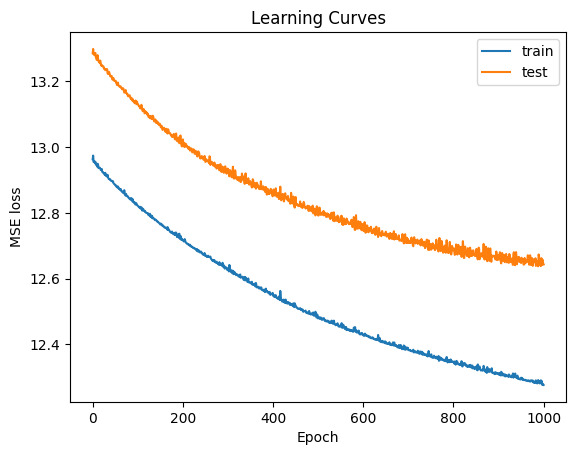

In [13]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.plot((history_fine.history['loss']), label='train')
plt.plot((history_fine.history['val_loss']), label='test')
plt.legend()
plt.show()

Overfitting can be observed as the training loss continues to decrease with the Epochs, improving the accuracy, while the test loss shows a slower decrease. With more training epochs the test loss should reach an asymptotic value and not decrease anymore. 

### 7) Testing the trained model on the initial case study

The trained model is now applied to a real case study, the GMI overpass of Medicane Ianos on 16/09/2020 seen before, and the reult will be compared with the surface precipitation estimates provided by the NASA Goddard Profiling Algorithm, the official GPM preciptiation product for the GMI radiometer. Some details on the GPROF algorithm can be found in <a href="https://gpm.nasa.gov/resources/documents/gpm-gprof-algorithm-theoretical-basis-document-atbd/">GPM GPROF Algorithm Theoretical Basis Document (ATBD)  </a>.


In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap 
from mpl_toolkits.basemap import Basemap
import numpy as np
import h5py
import warnings

# defining the function to plot
def plot_rr_map(RR,lat,lon,colorAxisMin,colorAxisMax):
    # set the lat/lon borders of the map
    latborders=[34,40]
    lonborders=[14,22]
    m = Basemap(projection='merc',
        resolution='l',
        lat_ts=20,
        llcrnrlat=latborders[0],urcrnrlat=latborders[1],\
        llcrnrlon=lonborders[0],urcrnrlon=lonborders[1])

    
#E set min/max values of the colorbar
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        im1 = m.pcolor(lon[:],lat[:],RR[:],shading='nearest',cmap='turbo',latlon=True,vmin=colorAxisMin,vmax=colorAxisMax)
    m.drawcoastlines()
# set parallels and meridians

    dparal=2 #separation in deg between drawn parallels
    parallels = np.arange(latborders[0],latborders[1],dparal)
    dmerid=2 #separation in deg between drawn meridians
    meridians = np.arange(lonborders[0],lonborders[1],dmerid)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=15)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=15) 
# add colorbar.
    cbar = m.colorbar(location='right',pad="5%")
    cbar.set_label('Rainfall Rate [mm/h]')
    
gmi_file_path='./1C-R.GPM.GMI.XCAL2016-C.20200916-S130832-E144106.037225.V07A.HDF5'
hf=h5py.File(gmi_file_path,'r')
lat1=hf['S1/Latitude'][:]
lon1=hf['S1/Longitude'][:]
TB1=hf['S1/Tc'][:]
TB2=hf['S2/Tc'][:]
hf.close()

TB=np.concatenate((TB1,TB2,),axis=2)
TB=np.reshape(TB,(2963*221,13))
TB[np.any(TB<=0,axis=1),:]=np.NaN
TB = scaler.transform(TB)
predictions = model.predict(TB)
predictions = np.reshape(predictions,(2963,221))


gprof_file_path='./2A.GPM.GMI.GPROF2021v1.20200916-S130832-E144106.037225.V07A.HDF5'
hf=h5py.File(gprof_file_path,'r')
lat2=hf['S1/Latitude'][:]
lon2=hf['S1/Longitude'][:]
gprof_rr=hf['S1/surfacePrecipitation'][:]
hf.close()

20464/20464 [==============================] - 27s 1ms/step


AttributeError: ignored

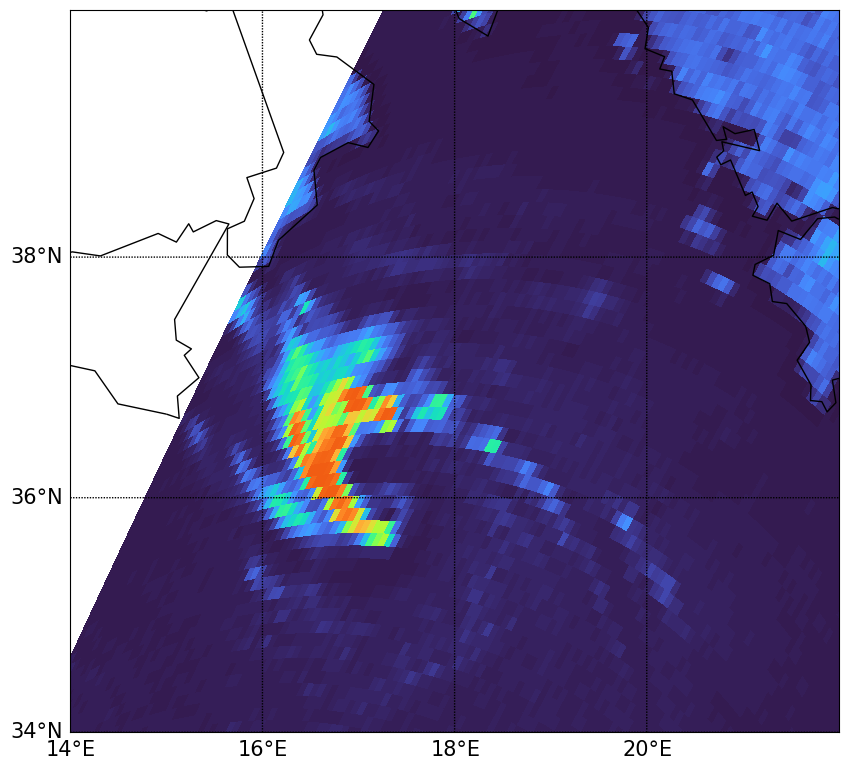

In [15]:

fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(121)
plot_rr_map(predictions,lat1,lon1,0,40)
plt.title('Exercise1 model',fontsize=12)
ax = fig.add_subplot(122)
plot_rr_map(gprof_rr,lat2,lon2,0,40)
plt.title('GPROF',fontsize=12)

The result obtained by our NN model seems quite acceptable, the rainfall patterns predicted by our model are quite similar to those of GPROF, which is based on a physically-based Bayesian approach and is a very complex algorithm. It is important to highlight that:
 1. The GMI observation of Madicane Ianos is not included in the training dataset (training dataset is built from 10 orbits of March 2014, while Medicane Ianos occured on 16/09/2020).
 2. The NN model precipitation rate estimates over land and coastal areas are not reliable, as the training dataset does not include measurements over land (the precipitation retrieval over land is much more complex than over ocean and it has not been address in this exercise).
 3. The high rainfall rates are underestimated, probably due to the small size of the training dataset, since intense rainfall is rare and probably it is not well represented in our limited-size training dataset.
 4. Very low precipitation rates are present also in areas where the GPROF algorithm does not predict any precipitation, since the training dataset includes only pixels with precipitation (rainfall rate > 0 mm/h), and it has not learned how to disciminate between rain and no-rain pixels (precipitation detection is often handled using a different ML approach).
 5. Remember that the trainig dataset is very small (10 orbits over ocean only) and the NN model obtained with this exercise is not suitable for operational or scientific purposes.

# Addtional Exercises

Using the following code try to train the model differently. In particular:

1. try to modify the learning rate and the epoch number (try learning rates 0.01, 0.002, 0.0005 0.0001)
2. modify the model architecture, varying the number of perceptrons in each hidden layer (40/10, 20/30)
3. try to remove one or more input GMI channels (e.g. the first two at 10 GHz which are more directly impacted by surface precipitation)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                280       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1600
4/4 [==============================] - 1s 70ms/step - loss: 32.0223 - mae: 2.4482 - val_loss: 33.0034 - val_mae: 2.4328
Epoch 2/1600
4/4 [==============================] - 0s 23ms/step - loss: 31.8881 - mae: 2.4208 - val_loss: 32.8696 - val_mae: 2.4055
Epoch 3/1600
4/4 [==============================] - 0s 23ms/step - loss: 31.7545 - mae: 2.3934 - val_loss: 32.7368 - val_mae: 2.3780
Epoch 4/1600
4/4 [==============================] - 0s 21ms/step - loss: 31.6219 - mae: 2.3659 - val_loss: 32.6042 - val_mae: 2.3504
Epoch 5/1600
4/4 [==============================] - 0s 23ms/step - loss: 31.4897 - mae: 2.3383 - val_loss: 32.4715 - val_mae: 2.3227
Epoch 6/1600
4/4 [==============================] - 0s 19ms/step - loss: 31.3570 - mae: 2.3106 - val_loss: 32.3385 - val_mae: 2.2955
Epoch 7/1600
4/4 [==============================] - 0s 20ms/step - loss: 31.2245 - mae: 2.2837 - val_loss: 32.2046 - val_mae: 2.2692
Epoch 8/1600
4/4 [==============================] - 0s 23ms/step - lo

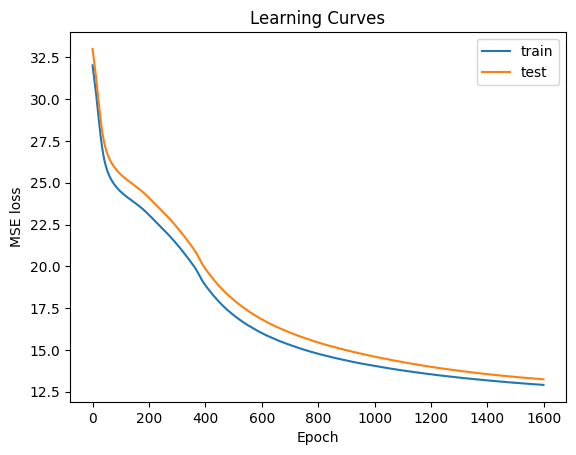

In [16]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import utils
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import xarray as xr

import warnings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# model hyperparameters
learning_rate1= 0.001  #the learning rate is the step size at each iteration while moving toward a minimum of a loss function
epochs = 1600          #An epoch in machine learning means one complete pass of the training dataset through the algorithm. 
batch_size = 8000      #the batch size is the number of training examples utilized in one iteration. A large batch size should make the training faster but may lead to memory saturation
num_percept_layer1=20  #number of perceptron 1st hidden layer
num_percept_layer2=10  #number of perceptron 2nd hidden layer



def load_dataset():
    warnings.filterwarnings("ignore")
    data_path = './dataset2_GMI_DPR_RR.nc'
    ds = xr.open_dataset(data_path)
    train_df = ds['tb'].to_dataframe().unstack()
    target = ds['rr'].to_dataframe()
    tensor_df = tf.convert_to_tensor(train_df, dtype=np.float)
    label_df = tf.convert_to_tensor(target, dtype=np.float)
    return tensor_df,label_df

def split_dataset(dataset, label_dataset):
    #split = round(test_split* len(tensor_df))
    choice=np.mod(range(0,len(tensor_df)),2)==0
    X_train = dataset[choice==0]
    X_test = dataset[choice]
    y_train = label_dataset[choice==0]
    y_test = label_dataset[choice]   
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(tensor_df, label_df)

# Scaling: Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #mean and variance are calculated on the training dataset and applied to the training dataset
X_test_scaled = scaler.transform(X_test)       #mean and variance (previously calculated) are applied to the test dataset

# Set the input shape
input_shape = X_train.shape[1]


def train():
    # here the network achitecture is defined: here it is a feed forward neural network with 2 hidden layers, 
    # Sigmoids are used as transfer function in both hidden layers.
    model = Sequential()
    model.add(Dense(num_percept_layer1, input_dim=input_shape, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(num_percept_layer2, kernel_initializer='normal', activation='sigmoid')) ###second hidden
    model.add(Dense(1, kernel_initializer='normal', activation='linear')) #output
    model.summary()
    #the optimizer is the algorithm used for the training. Adam is a standard choice, Scale conjugate gradient (SGD), is also very efficient.
    optimizer = optimizers.Adam(lr=learning_rate1)
    #optimizer = optimizers.experimental.SGD( learning_rate=learning_rate1)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) # the loss function to be minimized during training is the mean squared error (MSE)
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
    # We also carry out some validation to
    # monitor loss and metrics on the test dataset
    # at the end of each epoch
        validation_data=(X_test_scaled, y_test),)
        #validation_data=(X_test, np.log10(y_test)),)
    return model, history


verbose = 1
# training with the train dataset
model, history = train()

model.save('./exer2_model.h5')

# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.plot((history.history['loss']), label='train')
plt.plot((history.history['val_loss']), label='test')
plt.legend()
plt.show()